# oct-image-enhancement-optimisation
### CITS4404 Assignment 2 @ The University of Western Australia

Dennis Gunadi (**22374535**)\
Conan Dewitt (**22877792**)\
Alian Haidar (**22900426**)\
Lili Liu (**23212326**)

### Camo Worm Optimization for OCT Image Enhancement

This Jupyter notebook presents a project aimed at enhancing OCT (Optical Coherence Tomography) images using camo worms and optimizing the enhancement process through a genetic algorithm.

### Summary of Contents:

1. **Initialization and Constants:**
   - Constants and initialization code for setting up the environment, including image directory, image name, mask, population size, and population parameters.

2. **Image Preprocessing and Worm Creation:**
   - Functions for cropping images and preparing images for processing. Also, includes code for creating random worms with random attributes.

3. **Fitness Evaluation and Genetic Algorithm:**
   - Implementation of the genetic algorithm for optimizing the population of worms within the image. Includes functions for evaluating fitness, selecting fittest worms, performing crossover, and mating worms.

4. **Visualization and Result Analysis:**
   - Functions for visualizing the population of worms and analyzing the results of the genetic algorithm optimization process.

5. **Genetic Algorithm Execution:**
   - Execution of the genetic algorithm to optimize the population of worms for OCT image enhancement. Includes visualization of the initial population and the best generation obtained through optimization.

The genetic algorithm iteratively improves the distribution of worms within the OCT images by evaluating their fitness, selecting the fittest ones, and generating new generations through crossover and mutation. The process aims to enhance image features while ensuring color uniformity and minimizing deviation from the target intensity.

Import the required modules:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import imageio.v3 as iio

Include the custom [worm.py](worm.py) module:

In [2]:
import worm as wrm

Define global variables, including those for population parameters:

In [3]:
rng = np.random.default_rng()

IMAGE_DIR = 'images'
IMAGE_NAME = 'original'
MASK = [320, 560, 160, 880]  # y_min, y_max, x_min, x_max

POPULATION_SIZE = 40
POPULATION_PARAMS = (40, 30, 1)

Read, resize and display the input image:

Image name:     original
Image size:     240 720
Intensity max:  210
Intensity min:  0
Intensity mean: 49.3
Intensity std:  34.8


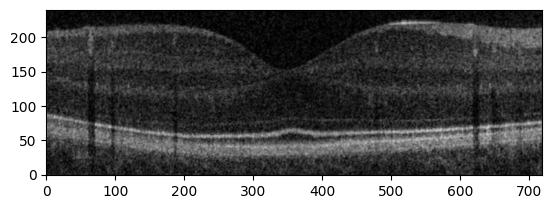

In [4]:
def crop(image, mask):
    h, w = np.shape(image)
    return image[max(mask[0],0):min(mask[1],h), max(mask[2],0):min(mask[3],w)]

def prep_image(imdir, imname, mask):
    image = np.flipud(crop(iio.imread(imdir+'/'+imname+".png"), mask))
    print("Image name:    ", imname)
    print("Image size:    ", *np.shape(image))
    print("Intensity max: ", np.max(image))
    print("Intensity min: ", np.min(image))
    print("Intensity mean:", round(np.mean(image), 1))
    print("Intensity std: ", round(np.std(image), 1))
    plt.imshow(image, vmin=0, vmax=255, cmap='gray', origin='lower')  # use vmin and vmax to stop imshow from scaling
    plt.show()
    return image

image = prep_image(IMAGE_DIR, IMAGE_NAME, MASK)

Calculate the cost associated with a given worm's position and color distribution within an image, considering the worm's environment, group knowledge, and internal knowledge:

- **Parameters:**
  - `worm`: The worm object for which the cost is calculated.
  - `image`: The input image in which the worm resides.
  - `other_worms`: A list of other worm objects in the image.

- **Environment Cost:**
  - Calculates the environment cost by comparing the intensity of the worm's position in the image to a target intensity.

- **Group Knowledge Cost:**
  - Computes the position cost based on the distance between the current worm and other worms in the image.

- **Internal Knowledge Cost:**
  - Calculates the color uniformity cost and color cost based on the worm's color distribution and the target colors in the image.
  - Combines all costs to derive the total cost.

The function returns the total cost, which is a composite measure of the factors mentioned above.

In [5]:
def calculate_cost(worm, image, other_worms):
    # Calculate Environment Cost
    # Extract the target intensity at the current position of the worm in the image
    target_intensity = image[int(worm.y), int(worm.x)] / 255.0
    
    # Generate Bézier curve points for the worm
    x_points, y_points = worm.bezier_points()
    
    # Ensure generated points are within the boundaries of the image
    x_points = np.clip(x_points, 0, image.shape[1]-1)
    y_points = np.clip(y_points, 0, image.shape[0]-1)
    
    # Extract pixel intensities from the image at the Bézier curve points
    intensity = image[y_points, x_points]
    
    # Calculate the environment cost by measuring the difference between the intensities
    # of worm pixels and the target intensity
    environment_cost = np.mean(np.abs(intensity - target_intensity))
    print(f'Environment cost: {environment_cost}')

    # Calculate Group Knowledge Cost
    position_cost = 0
    for other_worm in other_worms:
        if other_worm != worm:
            # Calculate Euclidean distance between the current worm and other worms
            distance = np.sqrt((worm.x - other_worm.x)**2 + (worm.y - other_worm.y)**2)
            position_cost += distance
    print(f'Position cost: {position_cost}')

    # Calculate Internal Knowledge Cost
    # Calculate color uniformity cost
    worm_points = np.column_stack((x_points, y_points))
    target_colors = image[worm_points[:, 1], worm_points[:, 0]]
    color_std_dev = np.std(target_colors, axis=0)
    color_uniformity_cost = np.sum(color_std_dev**2)
    print(f'Color Uniformity cost: {color_uniformity_cost}')

    # Calculate color cost
    color_cost = np.mean(np.abs(worm.color - target_colors))
    print(f'Color cost: {color_cost}')

    print('----------------------------------------')

    # Combine all costs to get the Total Cost
    total_cost = 0.2 * environment_cost - 0.008 * position_cost + color_cost + 0.15 * color_uniformity_cost
    return total_cost

Represents a population of worms and provides methods for initializing, evaluating fitness, selecting, and performing crossover operations on the population:
  
- **`create_random_worm(self, image_shape, init_params)`**:
  - Creates a random worm with random attributes based on the given image shape and initial parameters.

- **`evaluate_fitness(self, image, other_worms)`**:
  - Evaluates the fitness of each worm in the population based on a given image and other worms.

- **`select(self)`**:
  - Selects the fittest worms to survive and reproduce.

- **`crossover(self)`**:
  - Performs crossover to generate a new generation of worms.

- **`mate(self, parent1, parent2)`**:
  - Generates children by averaging attributes of two parent worms.

The class utilizes the above `calculate_cost()` function to evaluate the fitness of worms based on their positions and color distributions within the image.

In [6]:
class WormPopulation:
    def __init__(self, size, image_shape, init_params):
        """
        Initialize the WormPopulation object with a given size, image shape, and initial parameters for worm creation.

        Parameters:
            size (int): The number of worms in the population.
            image_shape (tuple): The shape of the image where the worms are placed.
            init_params (tuple): Tuple containing initial parameters for creating worms: 
                                 (radius_std, deviation_std, width_theta).
        """
        self.worms = [self.create_random_worm(image_shape, init_params) for _ in range(size)]
        self.image_shape = image_shape
        self.init_params = init_params

    def create_random_worm(self, image_shape, init_params):
        """
        Create a random worm with random attributes based on the given image shape and initial parameters.

        Parameters:
            image_shape (tuple): The shape of the image where the worm will be placed.
            init_params (tuple): Initial parameters for creating worms: (radius_std, deviation_std, width_theta).

        Returns:
            CamoWorm: A randomly generated worm object.
        """
        (radius_std, deviation_std, width_theta) = init_params
        (ylim, xlim) = image_shape

        # Randomly generate attributes for the worm
        midx = xlim * rng.random()
        midy = ylim * rng.random()
        r = radius_std * np.abs(rng.standard_normal())
        theta = rng.random() * np.pi
        deviation_r = deviation_std * np.abs(rng.standard_normal())
        deviation_gamma = rng.random() * np.pi
        width = width_theta * rng.standard_gamma(3)
        color = rng.random()

        return wrm.CamoWorm(midx, midy, r, theta, deviation_r, deviation_gamma, width, color)

    def evaluate_fitness(self, image, other_worms):
        """
        Evaluate the fitness of each worm in the population based on a given image and other worms.

        Parameters:
            image (numpy.ndarray): The image used for evaluating fitness.
            other_worms (list): List of other worms in the environment.
        """
        for worm in self.worms:
            worm.fitness = 1 / (1 + calculate_cost(worm, image, other_worms))

    def select(self):
        """
        Select the fittest worms to survive and reproduce.
        """
        self.worms.sort(key=lambda x: x.fitness, reverse=True)
        self.worms = self.worms[:len(self.worms) // 2]  # Keep top 50%
        self.worms = self.worms * 2

    def crossover(self):
        """
        Perform crossover to generate a new generation of worms.
        """
        new_generation = []
        while len(new_generation) < len(self.worms) * 2:
            if len(self.worms) >= 2:
                parent1, parent2 = np.random.choice(self.worms, 2, replace=False)
                child1, child2 = self.mate(parent1, parent2)
                new_generation.extend([child1, child2])
            else:
                break
        self.worms = new_generation[:len(self.worms)]

    def mate(self, parent1, parent2):
        """
        Generate children by averaging attributes of two parent worms.

        Parameters:
            parent1 (CamoWorm): First parent worm.
            parent2 (CamoWorm): Second parent worm.

        Returns:
            tuple: A tuple containing two generated child worms.
        """
        # Simple averaging crossover
        child1 = wrm.CamoWorm(
            (parent1.x + parent2.x) // 2,
            (parent1.y + parent2.y) // 2,
            (parent1.r + parent2.r) // 2,
            (parent1.theta + parent2.theta) / 2,
            (parent1.dr + parent2.dr) // 2,
            (parent1.dgamma + parent2.dgamma) / 2,
            (parent1.width + parent2.width) // 2,
            (parent1.color + parent2.color) / 2
        )
        child2 = wrm.CamoWorm(
            (parent1.x + parent2.x) // 2,
            (parent1.y + parent2.y) // 2,
            (parent1.r + parent2.r) // 2,
            (parent1.theta + parent2.theta) / 2,
            (parent1.dr + parent2.dr) // 2,
            (parent1.dgamma + parent2.dgamma) / 2,
            (parent1.width + parent2.width) // 2,
            (parent1.color + parent2.color) / 2
        )
        return child1, child2

This function orchestrates the genetic algorithm process for optimizing worm populations:

- **Parameters:**
  - `image`: The image used for optimization.
  - `generations` (optional): The number of generations for the genetic algorithm. Default is set to `POPULATION_SIZE`.

The function performs the following steps:

1. **Initialization:**
   - Initializes a worm population with the given size and image shape.

2. **Initial Population Visualization:**
   - Displays the initial population of worms.

3. **Genetic Algorithm Execution:**
   - Evaluates fitness, selects, and performs crossover operations for a given number of generations.
   - Mutates, grows, moves, and adapts color/curvature for each worm in the population.
   - Calculates and updates the minimum cost and best worms.

4. **Visualization of the Best Generation:**
   - Displays the best generation of worms along with its cost.

The function returns the optimized population of worms.

Initial population:


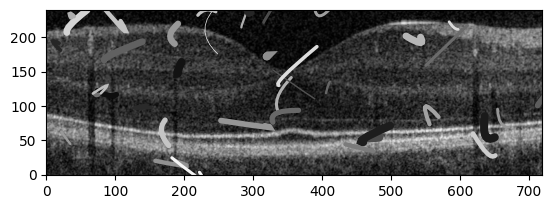

Environment cost: 55.113647058823545
Position cost: 10461.019268338889
Color Uniformity cost: 1576.0603999999998
Color cost: 54.40673668425896
----------------------------------------
Environment cost: 10.103882352941177
Position cost: 8351.580514799669
Color Uniformity cost: 40.6275
Color cost: 9.899548670053994
----------------------------------------
Environment cost: 119.65392156862741
Position cost: 10139.76430713776
Color Uniformity cost: 363.88749999999993
Color cost: 119.56574580067044
----------------------------------------
Environment cost: 51.385294117647064
Position cost: 14838.790639610324
Color Uniformity cost: 385.3275
Color cost: 50.74580993766499
----------------------------------------
Environment cost: 32.70000000000002
Position cost: 8861.078943471512
Color Uniformity cost: 57.94999999999999
Color cost: 32.73457377519784
----------------------------------------
Environment cost: 38.313921568627464
Position cost: 9328.125847022016
Color Uniformity cost: 100.78990000

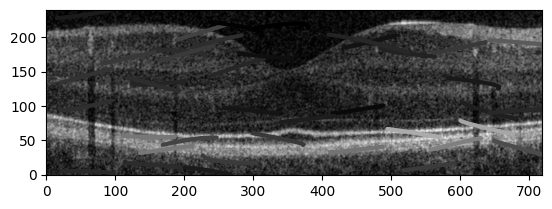

In [7]:
def run_genetic_algorithm(image, generations=POPULATION_SIZE):
    # Initialize population with given size and image shape
    population = WormPopulation(POPULATION_SIZE, image.shape, POPULATION_PARAMS)
    
    # Display initial population
    print("Initial population:")
    visualize_population(population.worms, image)
    
    # Track minimum cost and the best worms
    min_cost = float('inf')
    best_worms = None
    
    # Run genetic algorithm for a given number of generations
    for generation in range(generations):
        # Evaluate fitness, select, and perform crossover
        population.evaluate_fitness(image, population.worms)
        population.select()
        population.crossover()
        
        # Mutate, grow, move, and adapt color/curvature for each worm
        for worm in population.worms:
            worm.grow()
            worm.move(image.shape)
            worm.adapt_color(image)
            worm.adapt_curvature()
        
        # Calculate and update minimum cost and best worms
        cost = calculate_cost(worm, image, population.worms) / POPULATION_SIZE
        if cost < min_cost:
            min_cost = cost
            best_worms = population.worms.copy()
            for i, worm in enumerate(best_worms):
                print(f"Worm {i+1}:")
                print(f"x: {worm.x}")
                print(f"y: {worm.y}")
                print(f"r: {worm.r}")
                print(f"theta: {worm.theta}")
                print(f"deviation_r: {worm.dr}")
                print(f"deviation_gamma: {worm.dgamma}")
                print(f"width: {worm.width}")
                print(f"color: {worm.color}")
    
    # Display best generation and its cost
    print(f"Best generation: Cost = {min_cost}")
    visualize_population(best_worms, image)
    
    return population

def visualize_population(worms, image):
    # Visualize the population
    drawing = wrm.Drawing(image)
    drawing.add_worms(worms)
    drawing.show()

# Run
optimized_population = run_genetic_algorithm(image)